In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mat=scipy.io.loadmat('/Users/mandarmp/Documents/Projects/MEA_Server/MEA_Analysis/Matlab/basic_scripts/NetworkAct16795.mat')
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Aug  3 11:58:02 2023', '__version__': '1.0', '__globals__': [], 'firingRateNorm': array([[0.43289168],
       [0.47825024],
       [0.52225038],
       ...,
       [0.63909554],
       [0.58573945],
       [0.53004253]])}


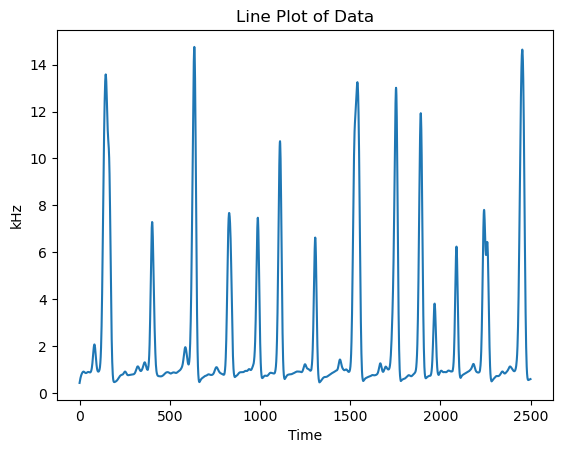

<Figure size 1000x500 with 0 Axes>

dict_keys(['__header__', '__version__', '__globals__', 'firingRateNorm'])
15001


In [57]:
data = mat['firingRateNorm']  # visualizing the data
plt.plot(data[0:2500])
plt.xlabel('Time')
plt.ylabel('kHz')
plt.title('Line Plot of Data')
plt.figure(figsize=(10, 5))
plt.show()
print(mat.keys())
total = len(data)
print(total)

In [58]:
#find the index of the highest point in each burst
burst_start = False
peak = 0
peak_list=[]
burst_start = False
peak_index_list=[]
peak_index = 0
threshold = 5
for x in range(1, total-2):
    if data[x] >= threshold and data[x] > data[x-1] and data[x] > data[x+1] and data[x] > peak:
        burst_start = True
        peak = data[x]
        peak_index = x
    if data[x] < 1 and burst_start == True:
        peak_list.append(peak)
        peak_index_list.append(peak_index)
        peak=0
        peak_index = 0
        burst_start = False  

print(peak_index_list)

[145, 402, 636, 829, 988, 1111, 1306, 1540, 1754, 1891, 2089, 2242, 2454, 2677, 2756, 2969, 3164, 3364, 3462, 3608, 3871, 4042, 4251, 4415, 4615, 4840, 5045, 5270, 5623, 5813, 5932, 6126, 6333, 6532, 6760, 6923, 7109, 7293, 7433, 7521, 7758, 7936, 8165, 8265, 8394, 8600, 8776, 9087, 9240, 9351, 9515, 9778, 10061, 10266, 10344, 10608, 10780, 11090, 11387, 11605, 11760, 11958, 12121, 12399, 12685, 12863, 13001, 13215, 13404, 13639, 13745, 14010, 14140, 14300, 14497, 14706]


In [67]:
#generating a list containing all the bursts/the values representing individual burst in the data starting from the index of the highest peaks.
list_of_burst = []
left_bound = 50
right_bound =50
for index in peak_index_list:
    individual_burst=np.array(data[index-left_bound:index+right_bound]).flatten()

    #individual_burst.sort()
    list_of_burst.append(individual_burst)

# #the values were represented as element in Numpy array, which make it impossible to perform PCC. Hence, the following codes extract the values out
# for i in range(0, len(list_of_burst)):
#     for x in range(0, len(list_of_burst[0])):
#         list_of_burst[i][x] = list_of_burst[i][x][0]

print(len(list_of_burst))

76


In [68]:
#generating the template, which is the average among the bursts
num_burst = len(list_of_burst)
point_on_burst = len(list_of_burst[0])
sum_of_burst = [0]*point_on_burst
for burst in list_of_burst:
    for x in range(point_on_burst):
        sum_of_burst[x] += burst[x]
    
template= [total / num_burst for total in sum_of_burst]

print(template)

[1.0047792772567767, 1.0031416977506027, 1.0017505827900486, 1.0004118100733728, 0.9993623124919616, 0.9990778933767493, 0.9996001684885257, 1.0011132742749445, 1.0038599666526984, 1.0080424050499792, 1.0140458304907294, 1.021977302994533, 1.0321867926998085, 1.0445233806346466, 1.0591417913604702, 1.0763430366185536, 1.0964317151151466, 1.1197177473949298, 1.1471059341585477, 1.1790968594927411, 1.2165041955471079, 1.2599253702288238, 1.3116671044823696, 1.374345614305616, 1.4506278969623325, 1.5427696292662307, 1.654473564846712, 1.7890336297130007, 1.9518789094042721, 2.148307296328275, 2.3819331538309934, 2.6553955616088847, 2.973972703419771, 3.339839121787245, 3.753978992262027, 4.218205467513641, 4.730892554852946, 5.289289120477798, 5.887921619533246, 6.5190418914030115, 7.172563899128818, 7.836388917893771, 8.49609122128283, 9.135104697635976, 9.736683804681793, 10.283243445948147, 10.757979682123388, 11.14533869691528, 11.431756076195304, 11.60638644209826, 11.662821789790707

[1.0047792772567767, 1.0031416977506027, 1.0017505827900486, 1.0004118100733728, 0.9993623124919616, 0.9990778933767493, 0.9996001684885257, 1.0011132742749445, 1.0038599666526984, 1.0080424050499792, 1.0140458304907294, 1.021977302994533, 1.0321867926998085, 1.0445233806346466, 1.0591417913604702, 1.0763430366185536, 1.0964317151151466, 1.1197177473949298, 1.1471059341585477, 1.1790968594927411, 1.2165041955471079, 1.2599253702288238, 1.3116671044823696, 1.374345614305616, 1.4506278969623325, 1.5427696292662307, 1.654473564846712, 1.7890336297130007, 1.9518789094042721, 2.148307296328275, 2.3819331538309934, 2.6553955616088847, 2.973972703419771, 3.339839121787245, 3.753978992262027, 4.218205467513641, 4.730892554852946, 5.289289120477798, 5.887921619533246, 6.5190418914030115, 7.172563899128818, 7.836388917893771, 8.49609122128283, 9.135104697635976, 9.736683804681793, 10.283243445948147, 10.757979682123388, 11.14533869691528, 11.431756076195304, 11.60638644209826, 11.662821789790707

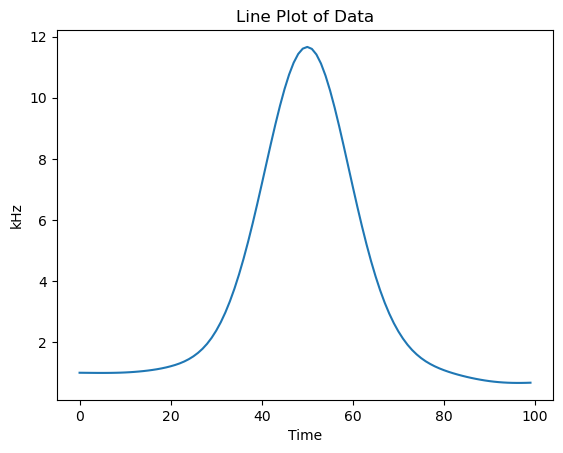

In [69]:
print(template)
plt.plot(template)
plt.xlabel('Time')
plt.ylabel('kHz')
plt.title('Line Plot of Data')
plt.show()

In [70]:
#find the pearson correlation coefficient between each individual burst and the template
pcc=[]
for burst in list_of_burst:
    pcc.append(np.corrcoef(burst, template)[0, 1])

print(pcc)
len(pcc)

[0.8916170672329469, 0.98503775435518, 0.9888285870410208, 0.9899766115911546, 0.9798487385907926, 0.9872876753283444, 0.966994640494708, 0.8863165060234267, 0.9862939014775985, 0.9939379425895835, 0.9638776396919898, 0.8384511876378461, 0.9841533663914738, 0.9880675564154436, 0.9196858594956197, 0.611225927746907, 0.9668788283035622, 0.9759454490934913, 0.9889800724284037, 0.9889087214947105, 0.9754160724938145, 0.9720281803004933, 0.9813989759178263, 0.9596727184470533, 0.9892902490273866, 0.9749823152027948, 0.9967776455313514, 0.8442239345158983, 0.984781937918096, 0.9676864593314364, 0.6810306382096968, 0.972544131241862, 0.9985246069424174, 0.9978323240932392, 0.9979752431153809, 0.9735262830051773, 0.986054362825511, 0.9968079287991177, 0.9699399949756908, 0.988079393647759, 0.993771333111988, 0.9714760672912701, 0.972425044457636, 0.9919858378936401, 0.9935701302692854, 0.9972972368348522, 0.9909664382580025, 0.9809640525675809, 0.9840514065962767, 0.9720946273748485, 0.9904591

76

In [71]:
#find the average PCC
sum = 0
for value in pcc:
    sum+=value
average_pcc= sum/(len(pcc))

print(average_pcc)

0.9652059063395839
